# This notebook performs a simulation of a rope where ANCF is used to model the large deformation

### Generalized form of Jourdain's Principle is used to develop the mass matrix

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import pickle

from IPython.display import display

from sympy import init_printing
init_printing(use_latex=True)

#### Define symbolic quantites

In [2]:
# nodal positons, velocities, and accelerations
"""
    e = [r1x r1y dr1xdx dr1ydx r2x r2y dr2xdx dr2ydx]
    e = 1x8 for a 2D beam
"""

# nodal positions
e = sym.Matrix(sym.symarray('e',8))
# nodal velocities
e_dot = sym.Matrix(sym.symarray('edot',len(e)))
# nodal accelerations
e_ddot = sym.Matrix(sym.symarray('eddot',len(e)))

# symbolic system parameters 
E, I, A, rho, x, l, tau_a = sym.symbols('E I A rho x l tau_a')
# x = sym.symbols('x')


### Compute the Mass Matrix

In [3]:
# define shape functions
s = sym.symarray('s',4)

s[0] = 1-3*(x/l)**2+2*(x/l)**3;
s[1] = x/l-2*(x/l)**2+(x/l)**3;
s[2] = 3*(x/l)**2-2*(x/l)**3;
s[3] = (x/l)**3-(x/l)**2;

# compute shape function matrix
S = sym.expand(sym.Matrix([s[0]*sym.eye(2), l*s[1]*sym.eye(2), s[2]*sym.eye(2), l*s[3]*sym.eye(2)])).T
# print('S = ')
# display(S)


# define velocity of all points on the beam
# print(S.shape)
# print(e_dot.shape)
Vp = S*e_dot
# print('\nVp = ')
# display(Vp)

# define partial velocities of the nodes 
V_r = sym.Matrix([[sym.diff(Vp[j],e_dot[i]) for j in range(len(Vp))] for i in range(len(e))]).T
# print('\nV_r = ')
# display(V_r)
# print()

# define acceleration of the nodes
Ap = S*e_ddot
# print('\nAp = ')
# display(Ap)
# print()

M = sym.Matrix([[sym.expand(sym.integrate(V_r[:,j].dot(Ap)*rho*A,(x,0,l))).coeff(e_ddot[i]) for i in range(len(e))]
                for j in range(len(e))])
# print('\nM = ')
# display(M)
pickle.dump( M, open( "ancf-mass-matrix.dump", "wb" ) )

### Compute Internal forces
(Berzeri, Shabana - 2000 - DEVELOPMENT OF SIMPLE MODELS FOR THE ELASTIC FORCES IN THE ABSOLUTE NODAL CO-ORDINATE FORMULATION)

#### Compute Longitudinal Strain Energy

In [4]:
# Compute epsilon with approximation 2 (78)
er = sym.Matrix([0, 0, 1, 0, 1, 0, 1, 0])
# diff_S_squared = sym.simplify(sym.expand(S.diff(x).T*S.diff(x)))
# epsilon_squared = sym.simplify((1/2*(e - er).T.dot(diff_S_squared*(e + er)))**2)
# diff_S_squared = sym.simplify(sym.expand(S.diff(x).T*S.diff(x)))
dSdx = S.diff(x)
epsilon_squared = sym.simplify((1/2*(e - er).T*dSdx.T).dot(dSdx*(e + er))**2)
# display(epsilon_squared)

Ul = sym.simplify(1/2*sym.integrate(E*A*epsilon_squared, (x,0,l)))

In [5]:
# diff_S_squared

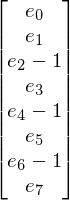

In [6]:
(e-er)

#### Compute Transverse Strain Energy

In [18]:
# Compute kappa (approximation 1: small longitudinal deformation - fine for rope)
kappa_squared = sym.simplify(sym.expand(e.dot(S.diff(x,x).T*S.diff(x,x)*e)))
# display(kappa_squared)

# Compute Transverse Strain Energy
Ut = 1/2*sym.integrate(E*I*kappa_squared, (x,0,l))

#### Compute Internal Forces $Q_e = \frac{\partial U}{\partial e}$

In [19]:
# Compute Total Energy
U = Ul + Ut

# Compute Internal Force Vector
Qe = sym.Matrix([sym.simplify(sym.expand(sym.diff(-U,node))) for node in e])

In [9]:
# sym.simplify(sym.diff(Ul,e[0]))
# sym.simplify(sym.diff(Ut,e[0]))

In [10]:
# sym.simplify(sym.diff(Ut,e[0]))

### Applied and body force vector

In [20]:
# Applied forces
# Gravity body force
fg = rho*9.81*A*sym.Matrix([0,-1])

# Applied torque
# torque_app = sym.Matrix([0,0,tau_a])

# Compute beta
# beta = sym.Matrix([sym.simplify(sym.integrate(vr.dot(fg), (x,0,l)) + qe) 
#                    for vr,qe in zip(V_r,Qe)])
beta = sym.Matrix([sym.simplify(sym.integrate(V_r[:,j].dot(fg), (x,0,l))) 
                   + qe for j,qe in zip(range(len(e)),Qe)])
pickle.dump( beta, open( "ancf-force-vector.dump", "wb" ) )

In [21]:
n = 2
theta = 0

modulus = 0.7e6
inertia = 1.215e-8
length = 0.12
area = 0.0018
density = 5540


state = np.array([[(i*length-length)*np.cos(theta), (i*length-length)*np.sin(theta), np.cos(theta), np.sin(theta),
                   (i*length)*np.cos(theta),        (i*length)*np.sin(theta),        np.cos(theta), np.sin(theta)] 
             for i in range(1,n+1)]).reshape(1,n*8).squeeze()
display(state)

array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.12,  0.  ,  1.  ,  0.  ,  0.12,
        0.  ,  1.  ,  0.  ,  0.24,  0.  ,  1.  ,  0.  ])

In [22]:
from numpy.linalg import inv

# Load symbolic mass matrix
M = pickle.load( open( "ancf-mass-matrix.dump", "rb" ) ).subs([(A, area), (l, length), (rho, density)])

# load the body and applied force vector (this still has sympolic 'e' values)
beta = pickle.load( open( "ancf-force-vector.dump", "rb" ) ).subs([(E, modulus), (A, area), \
                                                                   (I, inertia), (rho, density), (l, length)])
# Partition mass matrix
M11 = np.array(M[0:4,0:4])
M12 = np.array(M[0:4,4:8])
M21 = np.array(M[4:8,0:4])
M22 = np.array(M[4:8,4:8])

# For now 
lambda11 = np.eye(4)
lambda12 = np.zeros((4,4))
lambda22 = np.eye(4)
lambda21 = np.zeros((4,4))

# fully numberic (initial) values for body and applied forces

e_sub = [(e, ei) for e, ei in zip(e, state[:8])]
beta = beta.subs(e_sub)

# partition beta into lambda13 and lambda23
lambda13 = np.array(beta[0:4])
lambda23 = np.array(beta[4:8])
# Commonly inverted quantities
Gamma = inv(M11 - M12*inv(M22)*M21)
iM22 = inv(M22)

# Compute all terms of the two handle equations
zeta11 = Gamma.dot(lambda11 - M12.dot(iM22.dot(lambda21)))
zeta12 = Gamma.dot(lambda12 - M12.dot(iM22.dot(lambda22)))
zeta13 = Gamma.dot(lambda13 - M12.dot(iM22.dot(lambda23)))

zeta21 = iM22.dot(lambda21 - M21.dot(lambda11))
zeta22 = iM22.dot(lambda22 - M21.dot(lambda12))
zeta23 = iM22.dot(lambda23 - M21.dot(lambda13))

In [23]:
Ul_test = sym.simplify(sym.diff(Ul,e[0]).subs(e_sub).subs(\
                [(E, modulus), (A, area), (I, inertia), (rho, density), (l, length)]))
Ut_test = sym.simplify(sym.diff(Ut,e[0]).subs(e_sub).subs(\
                [(E, modulus), (A, area), (I, inertia), (rho, density), (l, length)]))

In [24]:
display(Ul_test)

In [25]:
# beta

In [17]:
# state[:8]